In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import ast
import re
import json
import pickle

import pydot
from IPython.display import Image, display

from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
#from langchain_core.pydantic_v1 import BaseModel, Field
#from langchain_core.messages import HumanMessage
#from langchain_core.runnables import chain
#from langchain_core.output_parsers import JsonOutputParser
#from langchain_community.callbacks import get_openai_callback

#from langchain_experimental.open_clip import OpenCLIPEmbeddings

#from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
import xml.etree.ElementTree as ET
import open_clip
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

load_dotenv()

/opt/conda/envs/libsearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [2]:
os.environ['AZURE_OPENAI_ENDPOINT'] = 'https://test-55-gpt4.openai.azure.com/'
os.environ['AZURE_OPENAI_API_KEY'] = 'xxx'
os.environ['CHAT_DEPLOYEMENT_NAME']='gpt-4-turbo'
os.environ['CHAT_MODEL_NAME']='gpt-4'
os.environ['CHAT_OPENAI_API_VERSION']='2024-02-15-preview'
os.environ['CHAT_OPEN_API_TYPE']='azure'

- revoir les attributes values (il manque des espaces) VVV
- renommer les models : llm_model, clip_model, classification_model VVV
- ajouter au dataset de train une colonne avec le image_name (pour faire des vérifs derrière) VVV
- retirer les features les moins importantes (cross multiclass) VVV
- tester Modèle d'arbre et feature permutation pour mesurer la feature importance VVV

- tracer l'AUC et ROC curve VVV
- comparer avec un CNN les metrics

- classer les visual_clues (features) / visual_parts / attributes les plus déterminantes VVV
- focus sur une image mal prédite : pourquoi ? VVV

# Get visual clues for each class_label

In [3]:
def get_visual_parts(class_domain:str):
    visual_parts_prompt = """
    I would like to get a dictionary (json format) of the main visual parts of a given domain, themselves subdivided in visual parts, and so on.
    A visual part is something concrete, and must not be a characteristic or attribute (size, shape, lenght, colour, texture, luminosity).
    The output should be a well-formatted JSON instance that conforms to the JSON schema below. Avoid spaces and '\n' in the output
    As an exemple for the schema: {{'visual_part_1': {{'visual_part_1.1' :{{}}}}, {{'visual_part_1.2': {{}}}}, 'visual_part_2': {{'visual_part_2.1':{{}}, 'visual_part_2.2' : {{'visual_part_2.2.1':{{}}, 'visual_part_2.2.2':{{}}}}, 'visual_part_2.3':{{}}}}, 'visual_part_3': {{}}}}
    If there is no more subdivision, the value of a key-value pair should be an empty Python dictionary.
    One exemple : if the domain is "plane", the schema should be : {{'fuselage':{{'cockpit':{{}}, 'corgo_holds':{{}}, 'passenger_seats':{{}}}}, 'wings':{{'ailerons':{{}}, 'trailing_edge':{{}}, 'leading_edge':{{}}}}, 'landing_gear':{{'wheels':'tyres':{{}}, 'rims':{{}}}}, 'brakes':{{}}}}, 'engine':{{'turbines':{{}}, 'compressors':{{}}}}}}
    The visual parts (and the subdivisions) should be precise, but not too much. Some limitations :
    - there should be between 5 and 10 visual_parts at the first level of the tree
    - then between 0 and 5 at the second level
    - then between 0 and 5 at the third level
    - there should not be more than 3 levels
    Avoid spaces and '\n' in the output, pure JSON format.
    The domain for which I need the dictionary is : {}
    """
    return visual_parts_prompt.format(class_domain)

In [4]:
def get_visual_attributes(visual_parts_dict:dict):
    visual_attributes_prompt = """
    I would like to get the visual attributes of things.
    Visual attriutes could be : size, lenght, width, shape, color, texture, luminosity, opacity, material, thickness, level or moisture, level of flexibility. Do not limit to this list, there could be far more relevant visual attributes according to the visual parts.
    It is important to be precise and not to generic.
    Some examples : 
    - the visual attributes for a flower petals are : 'size', 'shape', 'color', 'peduncle size', 'incurvation'
    - the visual attributes for a motor engine : 'speed', 'number of turbines', 'position in the car'
    - the visual attributes for teeth : 'size', 'color', 'sharpness', 'alignment', 'healthy level'
    Fill in each empty dictionary of the input dictionary below by the corresponding visual attributes of the dictionary key, and add en empty dictionary as visual attribute value.
    The output should be a well-formatted JSON instance that conforms to the JSON schema below. Avoid spaces and '\n' in the output.
    Format example : 
    - if the input is : {{'visual_part_1': {{'visual_part_1.1' :{{}}}}, {{'visual_part_1.2': {{}}}}, 'visual_part_2': {{'visual_part_2.1':{{}}, 'visual_part_2.2' : {{'visual_part_2.2.1':{{}}, 'visual_part_2.2.2':{{}}}}, 'visual_part_2.3':{{}}}}}}
    - the output should be : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : {{}}, visual_attributes_1.1.2 : {{}}}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : {{}}, visual_attributes_1.2.2 : {{}}, , visual_attributes_1.2.3 : {{}}}}}}}}
    There should be between 3 and 7 visual attribute for each visual part.
    The input dictionary is : {}
    """
    return visual_attributes_prompt.format(visual_parts_dict)

In [5]:
def get_attribute_values(visual_attributes_dict:dict, class_label:str, class_domain: str):
    attribute_values_prompt = """
    For a given subclass (e.g. dog breed), I would like to get the attribute value of each visual attribute (e.g. the size, the shape, the color...) of each visual part (e.g. head, body, legs...), taking into account the global class (e.g. dog).
    Some exemples : 
    for the global class 'dog', the subclass 'rottweiler', the visual part 'head', the sub_visual_part 'teeth', the values are :
    - for the visual attribute 'size' : ' quite large'
    - for the visual attribute 'color' : 'white'
    - for the visual attribute 'sharpness' : 'very sharp'
    - for the visual attribute 'alignement' : 'scissor bite'
    The value should consider how the subclass is postionned in the whole global_class ('rottweiler' are, among the 'dogs', those who have 'very sharp' 'teeth')
    Sometimes, try to be more precise than the split "low" / "medium" / "high" if you can. For instance, you can specify measurement intervals : e.g. "less than 5 inches" / "5-10 inches" / "more than 10 inches" (of course it depends on the unit of measurement)
    Replace each empty dictionary of the input dictionary below by the corresponding attribute value of the dictionary key.
    The output should be a well-formatted JSON instance that conforms to the JSON schema below. Avoid spaces and '\n' in the output.
    Format example :
    - if the input is :{{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : {{}}, visual_attributes_1.1.2 : {{}}}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : {{}}, visual_attributes_1.2.2 : {{}}, , visual_attributes_1.2.3 : {{}}}}}}}}
    - the output should be : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : attribute_value_1.1.1, visual_attributes_1.1.2 : attribute_value_1.1.2}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : attribute_value_1.2.1, visual_attributes_1.2.2 : attribute_value_1.2.2, , visual_attributes_1.2.3 : attribute_value_1.2.3}}}}}}
    The global class is : {}
    The subclass is : {}
    The input dictionary is : {}
    """
    return attribute_values_prompt.format(class_domain, class_label, visual_attributes_dict)

In [6]:
#def get_visual_clues_natural_language(visual_dict:dict):
#    visual_clues_sentences_prompt = """
#    The objective is to transform a nested Python dictionary into a list of natural language sentences.
#    The output should be a well-formatted Python list, where each item is a string sentence. Avoid spaces and '\n' in the output.
#    Format example :
#    - if the input is : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : attribute_value_1.1.1, visual_attributes_1.1.2 : attribute_value_1.1.2}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : attribute_value_1.2.1, visual_attributes_1.2.2 : attribute_value_1.2.2, , visual_attributes_1.2.3 : attribute_value_1.2.3}}}}}}
#    - the output should be like : ['the visual_attributes_1.1.1 of the visual_part_1.1 is attribute_value_1.1.1', 'the visual_attributes_1.1.2 of the visual_part_1.1 is attribute_value_1.1.2, 'the visual_attributes_1.2.1 of the visual_part_1.2 is attribute_value_1.2.1', 'the visual_attributes_1.2.2 of the visual_part_1.2 is attribute_value_1.2.2', 'the visual_attributes_1.2.3 of the visual_part_1.2 is attribute_value_1.2.3']
#    Make sure that final sentences is coherent.
#    The input dictionary is : {}
#    """
#    return visual_clues_sentences_prompt.format(visual_dict)

In [7]:
def get_visual_clues_natural_language(visual_dict:dict):
    visual_clues_sentences_prompt = """
    The objective is to transform a nested Python dictionary values in natural language sentences by aggregatings all information of the nested brand in the sentence.
    The output should be a well-formatted JSON instance, the same as the input, but with the values replaced by string sentences. Avoid spaces and '\n' in the output.
    Format example :
    - if the input is : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : attribute_value_1.1.1, visual_attributes_1.1.2 : attribute_value_1.1.2}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : attribute_value_1.2.1, visual_attributes_1.2.2 : attribute_value_1.2.2, , visual_attributes_1.2.3 : attribute_value_1.2.3}}}}}}
    - the output should be like : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : 'the visual_attributes_1.1.1 of the visual_part_1.1 is attribute_value_1.1.1', visual_attributes_1.1.2 : 'the visual_attributes_1.1.2 of the visual_part_1.1 is attribute_value_1.1.2'}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : 'the visual_attributes_1.2.1 of the visual_part_1.2 is attribute_value_1.2.1', visual_attributes_1.2.2 : 'the visual_attributes_1.2.2 of the visual_part_1.2 is attribute_value_1.2.2', , visual_attributes_1.2.3 : 'the visual_attributes_1.2.3 of the visual_part_1.2 is attribute_value_1.2.3'}}}}}}
    Make sure that sentences created are coherent.
    The input dictionary is : {}
    """
    return visual_clues_sentences_prompt.format(visual_dict)

In [8]:
def clean_visual_dict(visual_dict:dict):
    cleaning_dict_prompt = """
    could you remove spaces and '\n' in this text: {}
    """
    return cleaning_dict_prompt.format(visual_dict)

In [9]:
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [10]:
def get_visual_clues_class_domain_dict(class_domain:str, class_labels_list:list):
    
    llm_model = AzureChatOpenAI(
            temperature=0,
            deployment_name=os.getenv('CHAT_DEPLOYEMENT_NAME'),
            model_name=os.getenv('CHAT_MODEL_NAME'),
            openai_api_version=os.getenv('CHAT_OPENAI_API_VERSION'),
            openai_api_type=os.getenv('CHAT_OPEN_API_TYPE'),
            max_tokens=1024
        )
    
    # get visual parts dict of the class_domain
    visual_parts_dict = llm_model.predict(get_visual_parts(class_domain=class_domain))
    
    # enrich dict with all visual attributes for each visual part of the class_domain
    visual_parts_attributes_dict = llm_model.predict(get_visual_attributes(visual_parts_dict))
    clean_visual_parts_attributes_dict = re.sub(r' {2,}', '', visual_parts_attributes_dict).replace("\n", "")
    
    # now that we get the tree structure for the class_domain, let's have a dedicated dictionary for each class_label
    # we needed to ensure that visual_parts x visual_attributes are the same for all class_label
    class_domain_dict = {}
    
    for class_label in class_labels_list:
    
        # enrich dict with attribute values of the class_label for each visual attribute of the class_domain
        visual_parts_attributes_values_dict = llm_model.predict(get_attribute_values(visual_attributes_dict=clean_visual_parts_attributes_dict, class_label=class_label, class_domain=class_domain))
        clean_dict_str = re.sub(r' {2,}', '', visual_parts_attributes_values_dict).replace("\n", "")
        
        # transform attributes values by a natural language sentence that gathers all information of the visual clue (the tree branch)
        dict_with_sentences = llm_model.predict(get_visual_clues_natural_language(clean_dict_str))
        clean_dict_with_sentences = re.sub(r' {2,}', ' ', dict_with_sentences).replace("\n", "")
        clean_dict_with_sentences = ast.literal_eval(clean_dict_with_sentences)
        
        # flatten the dictionary by aggregating all branch information in one single key
        flatten_dict_class_label = flatten_dict(clean_dict_with_sentences)
        
        # add the class_label dict to the class_domain dict
        class_domain_dict[class_label] = flatten_dict_class_label
    
    return class_domain_dict

In [11]:
## final output should be
#class_domain_dict = {
#    class_labbel_1:{
#        visual_part_1_visual_part_1.1_visual_attribute_1.1.1 : visual_attribute_value_1.1.1_sentence,
#        visual_part_1_visual_part_1.1_visual_attribute_1.1.2 : visual_attribute_value_1.1.2_sentence,
#        visual_part_1_visual_part_1.2_visual_attribute_1.2.1 : visual_attribute_value_1.2.1_sentence,
#        visual_part_2_visual_part_2.1_visual_attribute_2.1.1 : visual_attribute_value_2.1.1_sentence},
#    class_label_2:{
#        ...
#    }
#}

In [12]:
%%time
class_domain = 'dog'
class_labels_list = ['Bulldog', 'Scotch Terrier', 'Beagle', 'Chihuahua', 'Saluki', 'Lhasa', 'Clumber', 'Doberman', 'Chow', 'African Hunting Dog']

class_domain_dict = get_visual_clues_class_domain_dict(class_domain=class_domain, class_labels_list=class_labels_list)

/opt/conda/envs/libsearch/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


CPU times: user 431 ms, sys: 28 ms, total: 459 ms
Wall time: 8min 32s


In [13]:
class_domain_dict

{'Bulldog': {'head_eyes_size': 'the size of the eyes is medium',
  'head_eyes_color': 'the color of the eyes is brown',
  'head_eyes_shape': 'the shape of the eyes is round',
  'head_eyes_luminosity': 'the luminosity of the eyes is low',
  'head_eyes_alignment': 'the alignment of the eyes is wide-set',
  'head_ears_size': 'the size of the ears is small',
  'head_ears_shape': 'the shape of the ears is floppy',
  'head_ears_texture': 'the texture of the ears is smooth',
  'head_ears_flexibility': 'the flexibility of the ears is low',
  'head_ears_fur_length': 'the fur length of the ears is short',
  'head_nose_size': 'the size of the nose is medium',
  'head_nose_shape': 'the shape of the nose is rounded',
  'head_nose_color': 'the color of the nose is black',
  'head_nose_texture': 'the texture of the nose is smooth',
  'head_mouth_size': 'the size of the mouth is wide',
  'head_mouth_shape': 'the shape of the mouth is broad',
  'head_mouth_color': 'the color of the mouth is pink',
  'h

In [14]:
with open("dog_visual_clues_dict_10.json", "w") as f:
    json.dump(class_domain_dict, f)

In [3]:
with open("dog_visual_clues_dict_10.json", "r") as f:
    class_domain_dict = json.load(f)

In [4]:
# reaarange visual clues

collected_values = {}

for sub_dict in class_domain_dict.values():
    for sub_key, value in sub_dict.items():
        if sub_key not in collected_values:
            collected_values[sub_key] = []  # Initialize a list if sub-key is encountered first time
        collected_values[sub_key].append(value)
        
collected_values = {key:list(set(value)) for key,value in collected_values.items()}

aggregated_visual_clues = [value for values in collected_values.values() for value in values]
aggregated_visual_clues = list(set(aggregated_visual_clues))
aggregated_visual_clues

['the texture of the fur is rough',
 'the color of the belly is lighter shade of body color',
 'the alignment of the eyes is forward facing',
 'the texture of the fur is coarse',
 'the flexibility of the ears is stiff',
 'the size of the paws is medium',
 'the size of the ears is large',
 'the claw sharpness of the hind paws is moderately sharp',
 'the size of the mouth is medium',
 'the fur texture of the neck is coarse',
 'the flexibility of the tail is high',
 'the size of the front legs paws is medium',
 'the fur texture of the neck is silky',
 'the length of the claws is short',
 'the claw sharpness of the front paws is moderately sharp',
 'the fur texture of the tail is smooth',
 'the size of the eyes is medium',
 'the alignment of the eyes is wide-set',
 'the alignment of the eyes is level',
 'the texture of the fur is straight',
 'the color of the nose is black',
 'the fur color of the back is mottled pattern of brown, black, and white',
 'the color of the fur matches head fur 

In [5]:
len(aggregated_visual_clues)

194

In [6]:
collected_values = {key:list(set(value)) for key,value in collected_values.items()}

In [7]:
sorted_dict = dict(sorted(collected_values.items(), key=lambda item: len(item[1]), reverse=True)[:10])
sorted_dict

{'head_fur_color': ['the color of the fur is black and tan',
  'the color of the fur is tricolor (black, white, and brown)',
  'the color of the fur is fawn, white, or brindle',
  'the color of the fur is cream, gold, red, grizzle and tan, tricolor, and black and tan',
  'the color of the fur is black',
  'the color of the fur is red, black, blue, fawn, cream',
  'the color of the fur is white with orange or lemon markings',
  'the color of the fur is varies',
  'the color of the fur is mottled pattern of brown, black, and white',
  'the color of the fur is varies (black, white, grey, golden)'],
 'body_fur_color': ['the color of the fur is black and tan',
  'the color of the fur is fawn, white, or brindle',
  'the color of the fur is black',
  'the color of the fur is red, black, blue, fawn, cream',
  'the color of the fur matches head fur color',
  'the color of the fur is white with orange or lemon markings',
  'the color of the fur is varies',
  'the color of the fur is tricolor',
 

In [8]:
# Load OpenCLIP model and preprocessing function
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")

In [9]:
def get_visual_clues_embeddings(visual_clues_list:list):

    visual_clues_embeddings = {}
    
    for visual_clue in visual_clues_list:
        tokens = open_clip.tokenize([visual_clue])
        with torch.no_grad():
            text_embedding = clip_model.encode_text(tokens)
        visual_clues_embeddings[visual_clue] = text_embedding
        
    return visual_clues_embeddings

In [10]:
%%time
visual_clues_embeddings = get_visual_clues_embeddings(aggregated_visual_clues)

CPU times: user 26.2 s, sys: 0 ns, total: 26.2 s
Wall time: 27.4 s


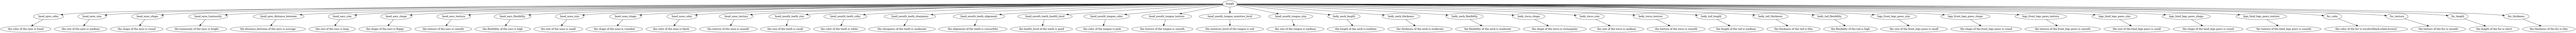

In [27]:
# display the tree of a given class_label

def dict_to_pydot(graph, class_domain_dict, class_label):
    """Recursively add nodes and edges from a nested dictionary to a pydot graph."""
    for key, value in class_domain_dict.items():
        node_name = f"{class_label}_{key}"
        graph.add_node(pydot.Node(node_name, label=key))
        graph.add_edge(pydot.Edge(class_label, node_name))
        
        # If the value is a dictionary, recursively add its children
        if isinstance(value, dict):
            dict_to_pydot(graph, value, node_name)
        else:
            # Create a leaf node for non-dict values
            leaf_name = f"{node_name}_{value}"
            graph.add_node(pydot.Node(leaf_name, label=str(value)))
            graph.add_edge(pydot.Edge(node_name, leaf_name))

# Create a new pydot graph
graph = pydot.Dot(graph_type='digraph')

# Add nodes and edges recursively from the nested dictionary
class_label = "beagle"
graph.add_node(pydot.Node(class_label))
dict_to_pydot(graph, class_domain_dict[class_label], class_label)

# Save the graph to a PNG file and display it
graph.write_png(f'{class_label}.png')
display(Image(filename=f'{class_label}.png'))

## test cells

In [98]:
llm_model = AzureChatOpenAI(
            temperature=0,
            deployment_name=os.getenv('CHAT_DEPLOYEMENT_NAME'),
            model_name=os.getenv('CHAT_MODEL_NAME'),
            openai_api_version=os.getenv('CHAT_OPENAI_API_VERSION'),
            openai_api_type=os.getenv('CHAT_OPEN_API_TYPE'),
            max_tokens=1024
        )

In [100]:
visual_parts_dict = llm_model.predict(get_visual_parts(class_domain='dog'))
visual_parts_dict

/opt/conda/envs/libsearch/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'{"head":{"eyes":{},"ears":{},"nose":{},"mouth":{},"fur":{}},"body":{"neck":{},"back":{},"belly":{},"fur":{}},"legs":{"front_legs":{"paws":{}},"hind_legs":{"paws":{}}},"tail":{},"paws":{"claws":{}}}'

In [101]:
visual_parts_attributes_dict = llm_model.predict(get_visual_attributes(visual_parts_dict))
visual_parts_attributes_dict

'{\n    "head": {\n        "eyes": {\n            "size": {},\n            "color": {},\n            "shape": {},\n            "luminosity": {},\n            "alignment": {}\n        },\n        "ears": {\n            "size": {},\n            "shape": {},\n            "texture": {},\n            "flexibility": {},\n            "fur_length": {}\n        },\n        "nose": {\n            "size": {},\n            "shape": {},\n            "color": {},\n            "texture": {}\n        },\n        "mouth": {\n            "size": {},\n            "shape": {},\n            "color": {},\n            "teeth_alignment": {},\n            "lip_thickness": {}\n        },\n        "fur": {\n            "color": {},\n            "texture": {},\n            "length": {},\n            "density": {}\n        }\n    },\n    "body": {\n        "neck": {\n            "length": {},\n            "thickness": {},\n            "fur_texture": {}\n        },\n        "back": {\n            "width": {},\n    

In [ ]:
updated_text = re.sub(r' {2,}', '', text)

In [102]:
clean_visual_parts_attributes_dict = visual_parts_attributes_dict.replace("\n", "")#.replace(" ", "")
clean_visual_parts_attributes_dict = re.sub(r' {2,}', '', clean_visual_parts_attributes_dict)
clean_visual_parts_attributes_dict

'{"head": {"eyes": {"size": {},"color": {},"shape": {},"luminosity": {},"alignment": {}},"ears": {"size": {},"shape": {},"texture": {},"flexibility": {},"fur_length": {}},"nose": {"size": {},"shape": {},"color": {},"texture": {}},"mouth": {"size": {},"shape": {},"color": {},"teeth_alignment": {},"lip_thickness": {}},"fur": {"color": {},"texture": {},"length": {},"density": {}}},"body": {"neck": {"length": {},"thickness": {},"fur_texture": {}},"back": {"width": {},"fur_length": {},"fur_color": {}},"belly": {"softness": {},"fur_density": {},"fur_color": {}},"fur": {"color": {},"texture": {},"length": {},"density": {}}},"legs": {"front_legs": {"paws": {"size": {},"fur_length": {},"claw_sharpness": {}}},"hind_legs": {"paws": {"size": {},"fur_length": {},"claw_sharpness": {}}}},"tail": {"length": {},"fur_density": {},"fur_color": {},"flexibility": {}},"paws": {"claws": {"sharpness": {},"length": {},"curvature": {}}}}'

In [103]:
visual_parts_attributes_values_dict = llm_model.predict(get_attribute_values(visual_attributes_dict=clean_visual_parts_attributes_dict, class_label='bulldog', class_domain='dog'))
visual_parts_attributes_values_dict

'{\n  "head": {\n    "eyes": {\n      "size": "small",\n      "color": "dark brown",\n      "shape": "round",\n      "luminosity": "low",\n      "alignment": "wide set"\n    },\n    "ears": {\n      "size": "medium",\n      "shape": "floppy",\n      "texture": "smooth",\n      "flexibility": "low",\n      "fur_length": "short"\n    },\n    "nose": {\n      "size": "small",\n      "shape": "rounded",\n      "color": "black",\n      "texture": "smooth"\n    },\n    "mouth": {\n      "size": "medium",\n      "shape": "wide",\n      "color": "pink",\n      "teeth_alignment": "scissor bite",\n      "lip_thickness": "thick"\n    },\n    "fur": {\n      "color": "fawn, white, or brindle",\n      "texture": "smooth",\n      "length": "short",\n      "density": "dense"\n    }\n  },\n  "body": {\n    "neck": {\n      "length": "short",\n      "thickness": "thick",\n      "fur_texture": "smooth"\n    },\n    "back": {\n      "width": "broad",\n      "fur_length": "short",\n      "fur_color": "mat

In [104]:
clean_dict_str = visual_parts_attributes_values_dict.replace("\n", "")
clean_dict_str = re.sub(r' {2,}', '', clean_dict_str)
clean_dict_str

'{"head": {"eyes": {"size": "small","color": "dark brown","shape": "round","luminosity": "low","alignment": "wide set"},"ears": {"size": "medium","shape": "floppy","texture": "smooth","flexibility": "low","fur_length": "short"},"nose": {"size": "small","shape": "rounded","color": "black","texture": "smooth"},"mouth": {"size": "medium","shape": "wide","color": "pink","teeth_alignment": "scissor bite","lip_thickness": "thick"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"body": {"neck": {"length": "short","thickness": "thick","fur_texture": "smooth"},"back": {"width": "broad","fur_length": "short","fur_color": "matches body"},"belly": {"softness": "moderate","fur_density": "dense","fur_color": "matches body"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"legs": {"front_legs": {"paws": {"size": "medium","fur_length": "short","claw_sharpness": "moderately sharp"}},"hind_legs":

In [105]:
dict_with_sentences = llm_model.predict(get_visual_clues_natural_language(clean_dict_str))#.replace("\n", "").replace(" ", "")
dict_with_sentences

'{\n  "head": {\n    "eyes": {\n      "size": "the size of the eyes is small",\n      "color": "the color of the eyes is dark brown",\n      "shape": "the shape of the eyes is round",\n      "luminosity": "the luminosity of the eyes is low",\n      "alignment": "the alignment of the eyes is wide set"\n    },\n    "ears": {\n      "size": "the size of the ears is medium",\n      "shape": "the shape of the ears is floppy",\n      "texture": "the texture of the ears is smooth",\n      "flexibility": "the flexibility of the ears is low",\n      "fur_length": "the fur length of the ears is short"\n    },\n    "nose": {\n      "size": "the size of the nose is small",\n      "shape": "the shape of the nose is rounded",\n      "color": "the color of the nose is black",\n      "texture": "the texture of the nose is smooth"\n    },\n    "mouth": {\n      "size": "the size of the mouth is medium",\n      "shape": "the shape of the mouth is wide",\n      "color": "the color of the mouth is pink",\

In [106]:
result = re.sub(r' {2,}', ' ', dict_with_sentences)
result = result.replace("\n", "")
result = ast.literal_eval(result)
result

{'head': {'eyes': {'size': 'the size of the eyes is small',
   'color': 'the color of the eyes is dark brown',
   'shape': 'the shape of the eyes is round',
   'luminosity': 'the luminosity of the eyes is low',
   'alignment': 'the alignment of the eyes is wide set'},
  'ears': {'size': 'the size of the ears is medium',
   'shape': 'the shape of the ears is floppy',
   'texture': 'the texture of the ears is smooth',
   'flexibility': 'the flexibility of the ears is low',
   'fur_length': 'the fur length of the ears is short'},
  'nose': {'size': 'the size of the nose is small',
   'shape': 'the shape of the nose is rounded',
   'color': 'the color of the nose is black',
   'texture': 'the texture of the nose is smooth'},
  'mouth': {'size': 'the size of the mouth is medium',
   'shape': 'the shape of the mouth is wide',
   'color': 'the color of the mouth is pink',
   'teeth_alignment': 'the teeth alignment of the mouth is scissor bite',
   'lip_thickness': 'the lip thickness of the mo

In [107]:
flatten_dict_class_label = flatten_dict(result)
flatten_dict_class_label

{'head_eyes_size': 'the size of the eyes is small',
 'head_eyes_color': 'the color of the eyes is dark brown',
 'head_eyes_shape': 'the shape of the eyes is round',
 'head_eyes_luminosity': 'the luminosity of the eyes is low',
 'head_eyes_alignment': 'the alignment of the eyes is wide set',
 'head_ears_size': 'the size of the ears is medium',
 'head_ears_shape': 'the shape of the ears is floppy',
 'head_ears_texture': 'the texture of the ears is smooth',
 'head_ears_flexibility': 'the flexibility of the ears is low',
 'head_ears_fur_length': 'the fur length of the ears is short',
 'head_nose_size': 'the size of the nose is small',
 'head_nose_shape': 'the shape of the nose is rounded',
 'head_nose_color': 'the color of the nose is black',
 'head_nose_texture': 'the texture of the nose is smooth',
 'head_mouth_size': 'the size of the mouth is medium',
 'head_mouth_shape': 'the shape of the mouth is wide',
 'head_mouth_color': 'the color of the mouth is pink',
 'head_mouth_teeth_alignmen

In [108]:
clean_dict_str

'{"head": {"eyes": {"size": "small","color": "dark brown","shape": "round","luminosity": "low","alignment": "wide set"},"ears": {"size": "medium","shape": "floppy","texture": "smooth","flexibility": "low","fur_length": "short"},"nose": {"size": "small","shape": "rounded","color": "black","texture": "smooth"},"mouth": {"size": "medium","shape": "wide","color": "pink","teeth_alignment": "scissor bite","lip_thickness": "thick"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"body": {"neck": {"length": "short","thickness": "thick","fur_texture": "smooth"},"back": {"width": "broad","fur_length": "short","fur_color": "matches body"},"belly": {"softness": "moderate","fur_density": "dense","fur_color": "matches body"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"legs": {"front_legs": {"paws": {"size": "medium","fur_length": "short","claw_sharpness": "moderately sharp"}},"hind_legs":

In [111]:
visual_dict

{'bulldog': '{"head": {"eyes": {"size": "small","color": "dark brown","shape": "round","luminosity": "low","alignment": "wide set"},"ears": {"size": "medium","shape": "floppy","texture": "smooth","flexibility": "low","fur_length": "short"},"nose": {"size": "small","shape": "rounded","color": "black","texture": "smooth"},"mouth": {"size": "medium","shape": "wide","color": "pink","teeth_alignment": "scissor bite","lip_thickness": "thick"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"body": {"neck": {"length": "short","thickness": "thick","fur_texture": "smooth"},"back": {"width": "broad","fur_length": "short","fur_color": "matches body"},"belly": {"softness": "moderate","fur_density": "dense","fur_color": "matches body"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"legs": {"front_legs": {"paws": {"size": "medium","fur_length": "short","claw_sharpness": "moderately sharp"}},

In [114]:
def dict_to_pydot(graph, data, parent_name):
    """Recursively add nodes and edges from a nested dictionary to a pydot graph."""
    for key, value in data.items():
        node_name = f"{parent_name}_{key}"
        graph.add_node(pydot.Node(node_name, label=key))
        graph.add_edge(pydot.Edge(parent_name, node_name))
        
        # If the value is a dictionary, recursively add its children
        if isinstance(value, dict):
            dict_to_pydot(graph, value, node_name)
        else:
            # Create a leaf node for non-dict values
            leaf_name = f"{node_name}_{value}"
            graph.add_node(pydot.Node(leaf_name, label=str(value)))
            graph.add_edge(pydot.Edge(node_name, leaf_name))

# Create a new pydot graph
graph = pydot.Dot(graph_type='digraph')

# Add nodes and edges recursively from the nested dictionary
root_name = "bulldog"
visual_dict = {}
visual_dict[root_name] = ast.literal_eval(clean_dict_str)
graph.add_node(pydot.Node(root_name))
dict_to_pydot(graph, visual_dict[root_name], root_name)

# Save the graph to a PNG file and display it
graph.write_png('bulldog.png')
display(Image(filename='bulldog.png'))

TypeError: 'module' object is not callable

# Train classification model

In [10]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    bboxes = []
    
    # Extract bounding box coordinates
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((xmin, ymin, xmax, ymax))
    
    return bboxes

In [11]:
def get_image_cosine_similarities(image_name, image_dir, label_dir, annotation_dir, text_embeddings):
    
    image_path = os.path.join(image_dir, label_dir, image_name+'.jpg')
    annotation_path = os.path.join(annotation_dir, label_dir, image_name)
    
    # get the bounding boxes of the image to know where the important part is located on the image
    # and cropp the image
    bounding_boxes = parse_annotation(annotation_path)
    image = Image.open(image_path)
    cropped_image = image.crop(bounding_boxes[0])
    inputs = preprocess(cropped_image).unsqueeze(0)

    # get image embedding from CLIP
    with torch.no_grad():
        img_embedding = clip_model.encode_image(inputs)
    
    # calculate cosine similarity between the image and each visual clue sentence
    image_texts_similarities = {text: F.cosine_similarity(img_embedding, text_embedding, dim=-1).item() for text, text_embedding in text_embeddings.items()}
    
    return image_texts_similarities

In [31]:
%%time
# create classification dataframe

image_dir='../stanford-dogs/images/Images'
annotation_dir = '../stanford-dogs/annotations/Annotation'

selected_class_labels = ['French_bulldog', 'Scotch_terrier', 'beagle', 'Chihuahua', 'Saluki', 'Lhasa', 'clumber', 'Doberman', 'chow', 'African_hunting_dog']
class_label_folder = [folder for folder in os.listdir(image_dir) if any(class_label in folder for class_label in selected_class_labels)]

df_classification = pd.DataFrame(columns=['class_label', 'image_name']+aggregated_visual_clues)

for folder in class_label_folder:
    
    folder_path = os.path.join(annotation_dir, folder)
    class_label = folder.split('-')[1]
    image_names = [img for img in os.listdir(folder_path) if '.ipynb_checkpoints' not in img]
    
    for image_name in image_names:
        image_text_similarities = get_image_cosine_similarities(image_name=image_name,
                                                                image_dir=image_dir,
                                                                label_dir=folder,
                                                                annotation_dir=annotation_dir,
                                                                text_embeddings=visual_clues_embeddings)
        image_text_similarities['class_label'] = class_label
        image_text_similarities['image_name'] = image_name
        df_classification = pd.concat([df_classification, pd.DataFrame.from_dict(image_text_similarities, orient='index').T])

CPU times: user 6min 48s, sys: 923 ms, total: 6min 49s
Wall time: 7min 26s


In [32]:
df_classification

class_label       image_name the fur texture of the neck is smooth  \
0    Chihuahua   n02085620_3045                              0.161216   
0    Chihuahua   n02085620_3942                              0.203049   
0    Chihuahua   n02085620_3402                              0.204543   
0    Chihuahua   n02085620_4673                              0.186748   
0    Chihuahua   n02085620_1569                              0.207945   
..         ...              ...                                   ...   
0     Doberman   n02107142_4632                              0.183794   
0     Doberman     n02107142_21                              0.198733   
0     Doberman  n02107142_17564                              0.185798   
0     Doberman  n02107142_13677                              0.179991   
0     Doberman    n02107142_413                              0.173632   

   the flexibility of the ears is stiff  \
0                              0.182279   
0                              0.277777   
0                              0.255857   
0                              0.237095   
0                               0.21764   
..                                  ...   
0                              0.263383   
0                              0.229712   
0                              0.238111   
0                              0.233249   
0                              0.202801   

   the fur length of the hind_legs paws is short  \
0                                       0.167816   
0                                       0.206465   
0                                       0.202277   
0                                        0.16615   
0                                       0.225167   
..                                           ...   
0                                       0.227447   
0                                       0.171864   
0                                       0.184428   
0                                       0.184951   
0                                       0.215938   

   the claw sharpness of the hind paws is very sharp  \
0                                           0.156847   
0                                           0.205923   
0                                           0.210075   
0                                           0.174659   
0                                           0.163324   
..                                               ...   
0                                            0.22897   
0                                           0.166934   
0                                           0.184391   
0                                           0.205507   
0                                           0.192628   

   the color of the fur is red, black, blue, fawn, cream  \
0                                            0.210202      
0                                            0.247919      
0                                            0.211503      
0                                            0.203893      
0                                            0.255428      
..                                                ...      
0                                             0.22819      
0                                            0.199631      
0                                            0.171251      
0                                            0.212963      
0                                            0.177376      

   the claw sharpness of the front paws is very sharp  \
0                                             0.17869   
0                                            0.231452   
0                                            0.226324   
0                                            0.209217   
0                                            0.198794   
..                                                ...   
0                                            0.239728   
0                                            0.207249   
0                                            0.195019   
0                   

In [33]:
df_classification.to_csv('dog_visual_clues_similarities_10.csv', index=False)

In [93]:
df_classification = pd.read_csv('dog_visual_clues_similarities_10.csv')

In [97]:
df_classification = df_classification.reset_index(drop=True)
X = df_classification.drop(columns=['class_label', 'image_name'])
y = df_classification['class_label']

# we train the model with most important features
with open('most_important_features.pkl', 'rb') as f:
    most_important_features_list = pickle.load(f)
X = X[most_important_features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# we keep a X_test_label dataframe to make some further analysis on bad predictions
#X_train = X_train.drop(columns=['class_label', 'image_name'])
#X_test_label = X_test.copy()
#X_test = X_test.drop(columns=['class_label', 'image_name'])

#param_grid = {
#    "n_estimators": [100, 200],
#    "max_depth": [None, 10, 20],
#    "min_samples_split": [2, 5, 10],
#    "min_samples_leaf": [1, 2, 4],
#    "max_features": ["sqrt", "log2"],
#}
#
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
#grid_search.fit(X_train, y_train)
#model = grid_search.best_estimator_

#model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

#model = RandomForestClassifier(n_estimators=200,
#                               max_depth=None,
#                               max_features='log2',
#                               min_samples_leaf=1,
#                               min_samples_split=2,
#                               random_state=42)

model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8950
Precision: 0.8951
Recall: 0.8950
F1 Score: 0.8938


In [98]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

African_hunting_dog       0.84      1.00      0.92        27
          Chihuahua       0.79      0.68      0.73        28
           Doberman       0.91      0.83      0.87        24
     French_bulldog       0.97      0.94      0.96        34
              Lhasa       0.89      0.87      0.88        39
             Saluki       0.89      0.89      0.89        36
     Scotch_terrier       0.92      0.87      0.89        38
             beagle       0.88      0.94      0.91        32
               chow       0.92      0.94      0.93        52
            clumber       0.89      0.94      0.91        33

           accuracy                           0.90       343
          macro avg       0.89      0.89      0.89       343
       weighted avg       0.90      0.90      0.89       343



In [17]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

# Plot outputs

In [110]:
# Get feature importances from the model
importances = model.feature_importances_
feature_names = list(X_train.columns)
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

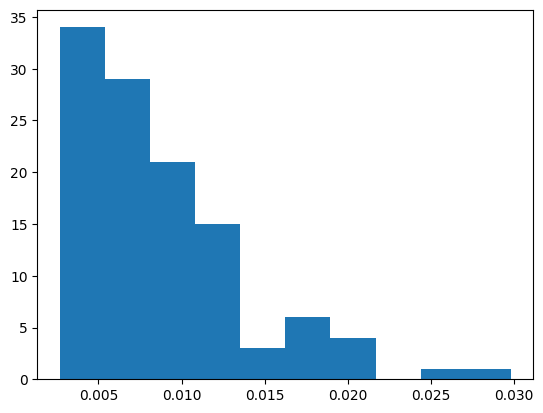

In [101]:
plt.hist(importance_df.Importance);

In [64]:
# Permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance", ascending=False)

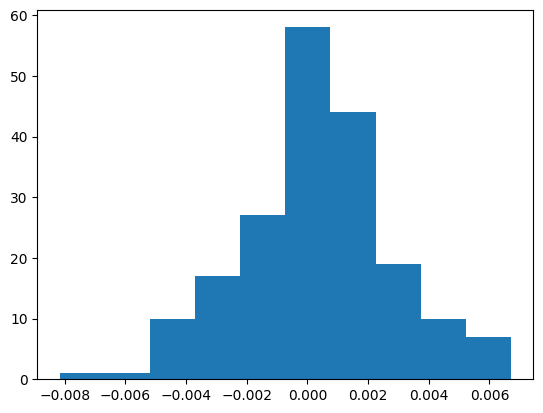

In [66]:
plt.hist(perm_importance_df.Importance);

## top class features

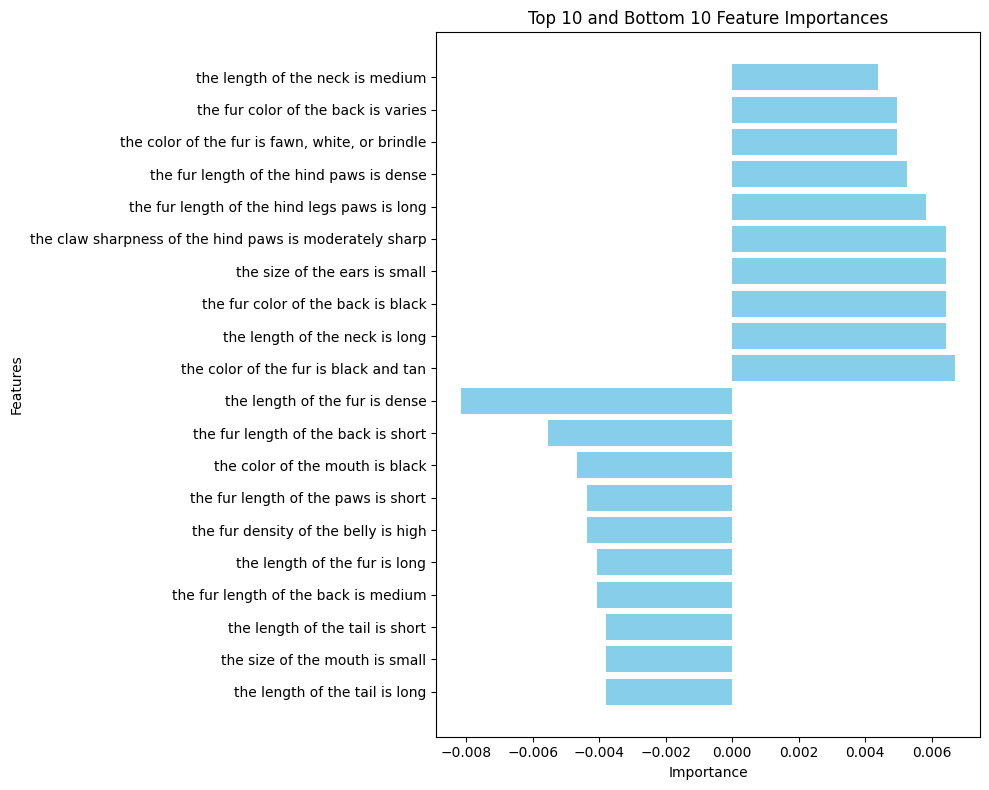

In [163]:
top_10 = perm_importance_df.tail(10)
bottom_10 = perm_importance_df.head(10)

# Combine the two
top_and_bottom = pd.concat([top_10, bottom_10])

plt.figure(figsize=(10, 8))
plt.barh(top_and_bottom["Feature"], top_and_bottom["Importance"])
plt.title("Top 10 and Bottom 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## top visual parts/attributes/clues

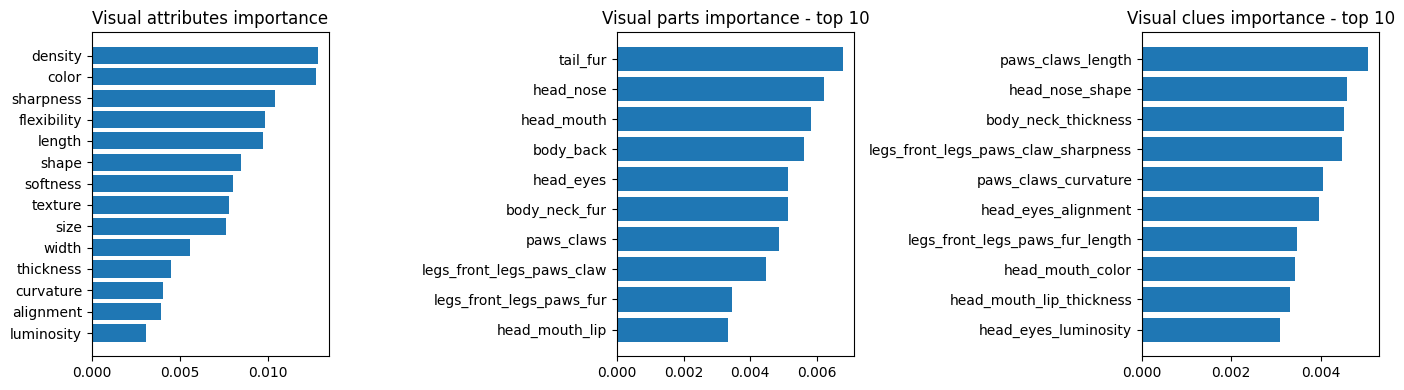

In [162]:
# we rank best visual parts / attributes to classify dogs

def map_to_visual_clue(value):
    for key, values in collected_values.items():
        if value in values:
            return key
    return None

importance_df['visual_clue'] = importance_df['Feature'].apply(map_to_visual_clue)
importance_df['attribute'] = importance_df['visual_clue'].apply(lambda x: x.split('_')[-1])
importance_df['visual_part'] = importance_df['visual_clue'].apply(lambda x: "_".join(x.split('_')[:-1]))

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(14,4))

attributes_importance = importance_df.groupby('attribute')['Importance'].mean().sort_values(ascending=True)
axes[0].barh(attributes_importance.index, attributes_importance);
axes[0].set_title('Visual attributes importance');

visual_part_importance = importance_df.groupby('visual_part')['Importance'].mean().sort_values(ascending=True)[:-12]
axes[1].barh(visual_part_importance.index, visual_part_importance);
axes[1].set_title('Visual parts importance - top 10');

visual_clue_importance = importance_df.groupby('visual_clue')['Importance'].mean().sort_values(ascending=True)[:-29]
axes[2].barh(visual_clue_importance.index, visual_clue_importance);
axes[2].set_title('Visual clues importance - top 10');

plt.tight_layout()

## grid search feature importance threshold

Best Threshold: -0.003
Best Cross-Validation Accuracy: 0.8950437317784257
Number of Features Selected: 175


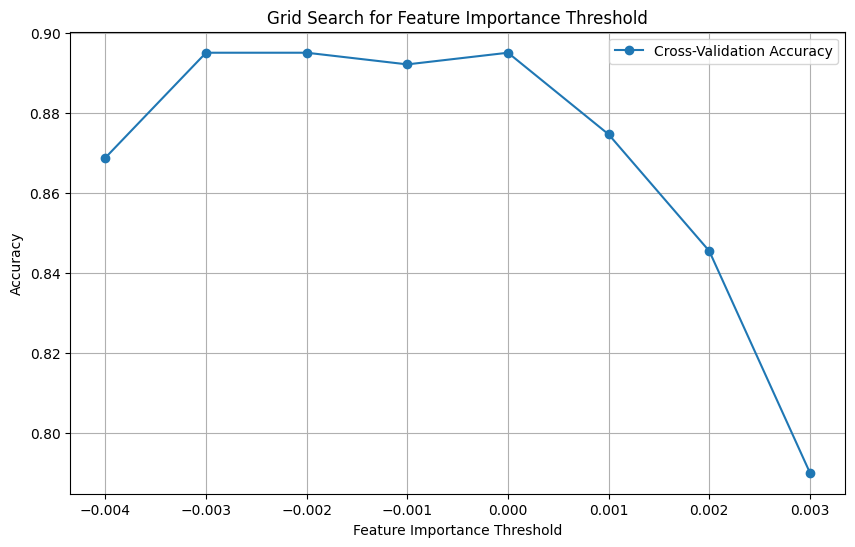

In [73]:
# we do a grid search to find the most optimal number of features to use 

def evaluate_with_threshold(threshold):
    #selected_features = list(importance_df[importance_df.Importance > threshold].Feature)
    selected_features = list(perm_importance_df[perm_importance_df.Importance > threshold].Feature)
    X_selected = X[selected_features]
    
    X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model_subset = RandomForestClassifier(random_state=42, n_jobs=-1)
    model_subset.fit(X_train_selected, y_train)
    
    y_pred_selected = model_subset.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred_selected)
    
    return accuracy, len(selected_features)  # Return mean score and number of features

#thresholds_importance = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
thresholds_perm_importance = [-0.004, -0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003]

results = []
for threshold in thresholds_perm_importance:
    accuracy, n_features = evaluate_with_threshold(threshold)
    results.append((threshold, accuracy, n_features))

best_threshold, best_score, best_n_features = max(results, key=lambda x: x[1])

print(f"Best Threshold: {best_threshold}")
print(f"Best Cross-Validation Accuracy: {best_score}")
print(f"Number of Features Selected: {best_n_features}")

thresholds, scores, n_features = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores, label='Cross-Validation Accuracy', marker='o')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('Accuracy')
plt.title('Grid Search for Feature Importance Threshold')
plt.legend()
plt.grid(True)
plt.show()

## ROC curve

In [83]:
y_binarized = label_binarize(y, classes=list(y.unique()))
y_test_binarized = label_binarize(y_test, classes=list(y.unique()))

n_classes = y_binarized.shape[1]

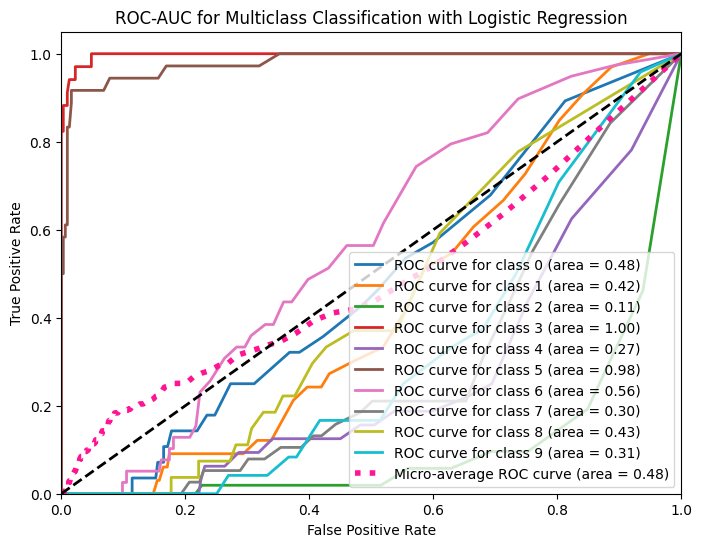

In [95]:
# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Multiclass Classification with Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [72]:
X_test_label['pred'] = y_pred
X_test_label = X_test_label[['class_label', 'image_name', 'pred']]
X_test_label.sample(5)

class_label       image_name                 pred
1084       Lhasa  n02098413_10144                Lhasa
943       Saluki   n02091831_1565  African_hunting_dog
261      clumber   n02101556_7295               Saluki
485         chow  n02112137_11858                 chow
494         chow  n02112137_18174                 chow

## Confusion matrix

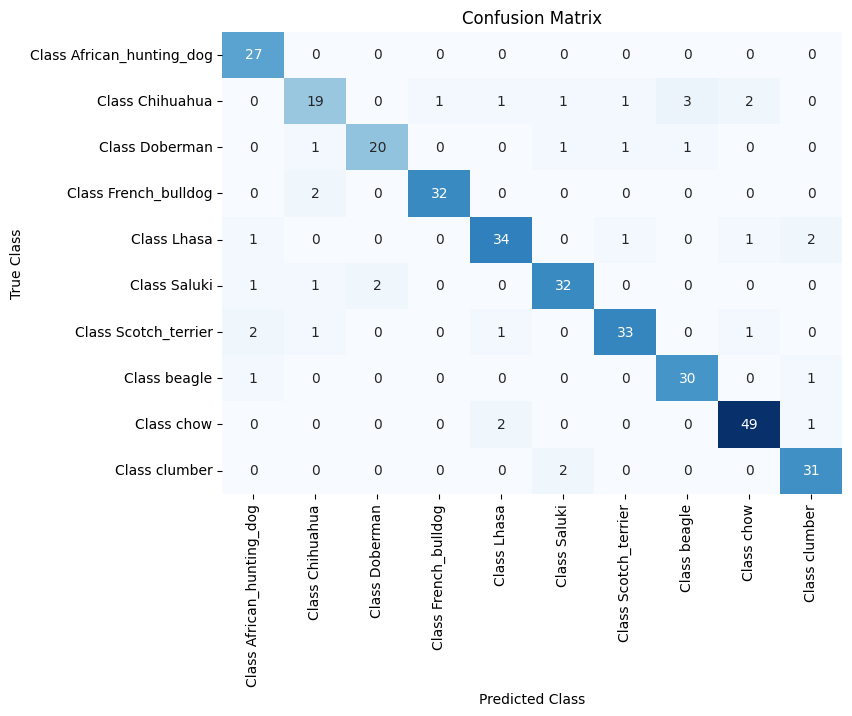

In [81]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=[f'Class {i}' for i in np.unique(y)],
            yticklabels=[f'Class {i}' for i in np.unique(y)])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

## top class_label features

In [165]:
# Focus on feature importance for each class_label
# For that, we need train one vs all logistic regression

ova_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
ova_model.fit(X_train, y_train)

feature_names = X_train.columns
coefficients = ova_model.coef_  # Shape: (n_classes, n_features)

# Convert to DataFrame for easier manipulation
feature_importances = pd.DataFrame(np.abs(coefficients).T,  # Use np.abs() to get absolute values
                                   index=feature_names,
                                   columns=y.unique())

feature_importances

/opt/conda/envs/libsearch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Chihuahua   clumber  \
the color of the fur is black and tan                2.169112  0.933441   
the length of the neck is long                       0.979214  0.674796   
the fur color of the back is black                   1.185710  1.061962   
the size of the ears is small                        0.153114  1.745675   
the claw sharpness of the hind paws is moderate...   2.984386  0.517694   
...                                                       ...       ...   
the fur color of the back is white with orange ...   0.015844  0.381621   
the shape of the nose is broad                       0.803431  0.873040   
the thickness of the tail is thin                    0.319538  0.279661   
the size of the hind legs paws is small              0.951242  1.040120   
the shape of the mouth is wide                       1.521007  1.127947   

                                                        chow  French_bulldog  \
the color of the fur is black and tan               2.085181        1.095311   
the length of the neck is long                      1.604822        0.194316   
the fur color of the back is black                  0.590449        0.008828   
the size of the ears is small                       0.344541        1.892973   
the claw sharpness of the hind paws is moderate...  0.232850        0.841112   
...                                                      ...             ...   
the fur color of the back is white with orange ...  0.719356        1.335231   
the shape of the nose is broad                      0.060387        0.528214   
the thickness of the tail is thin                   0.308408        0.486336   
the size of the hind legs paws is small             0.908665        0.358983   
the shape of the mouth is wide                      1.061236        0.210846   

                                                      beagle    Saluki  \
the color of the fur is black and tan               0.891978  1.555855   
the length of the neck is long                      1.214236  2.275944   
the fur color of the back is black                  0.135552  0.649409   
the size of the ears is small                       0.564196  1.273118   
the claw sharpness of the hind paws is moderate...  1.505223  1.250268   
...                                                      ...       ...   
the fur color of the back is white with orange ...  0.147582  0.726448   
the shape of the nose is broad                      0.245637  0.425724   
the thickness of the tail is thin                   0.628786  1.709572   
the size of the hind legs paws is small             1.440040  0.463828   
the shape of the mouth is wide                      0.342895  0.425911   

                                                       Lhasa  Scotch_terrier  \
the color of the fur is black and tan               0.747516        0.271238   
the length of the neck is long                      0.482846        0.240217   
the fur color of the back is black                  3.041376        2.484558   
the size of the ears is small                       0.779180        0.422820   
the claw sharpness of the hind paws is moderate...  0.804252        0.386016   
...                                                      ...             ...   
the fur color of the back is white with orange ...  1.459543        0.177830   
the shape of the nose is broad                      0.959343        0.952910   
the thickness of the tail is thin                   1.303934        0.274614   
the size of the hind legs paws is small             0.916478        1.367864   
the shape of the mouth is wide                      0.170667        0.433213   

                                                    African_hunting_dog  \
the color of the fur is black and tan                          2.325769   
the length of the neck is long                                 0.578566   
the fur color of the back is black                             1.188820   
the size of the ears is small           

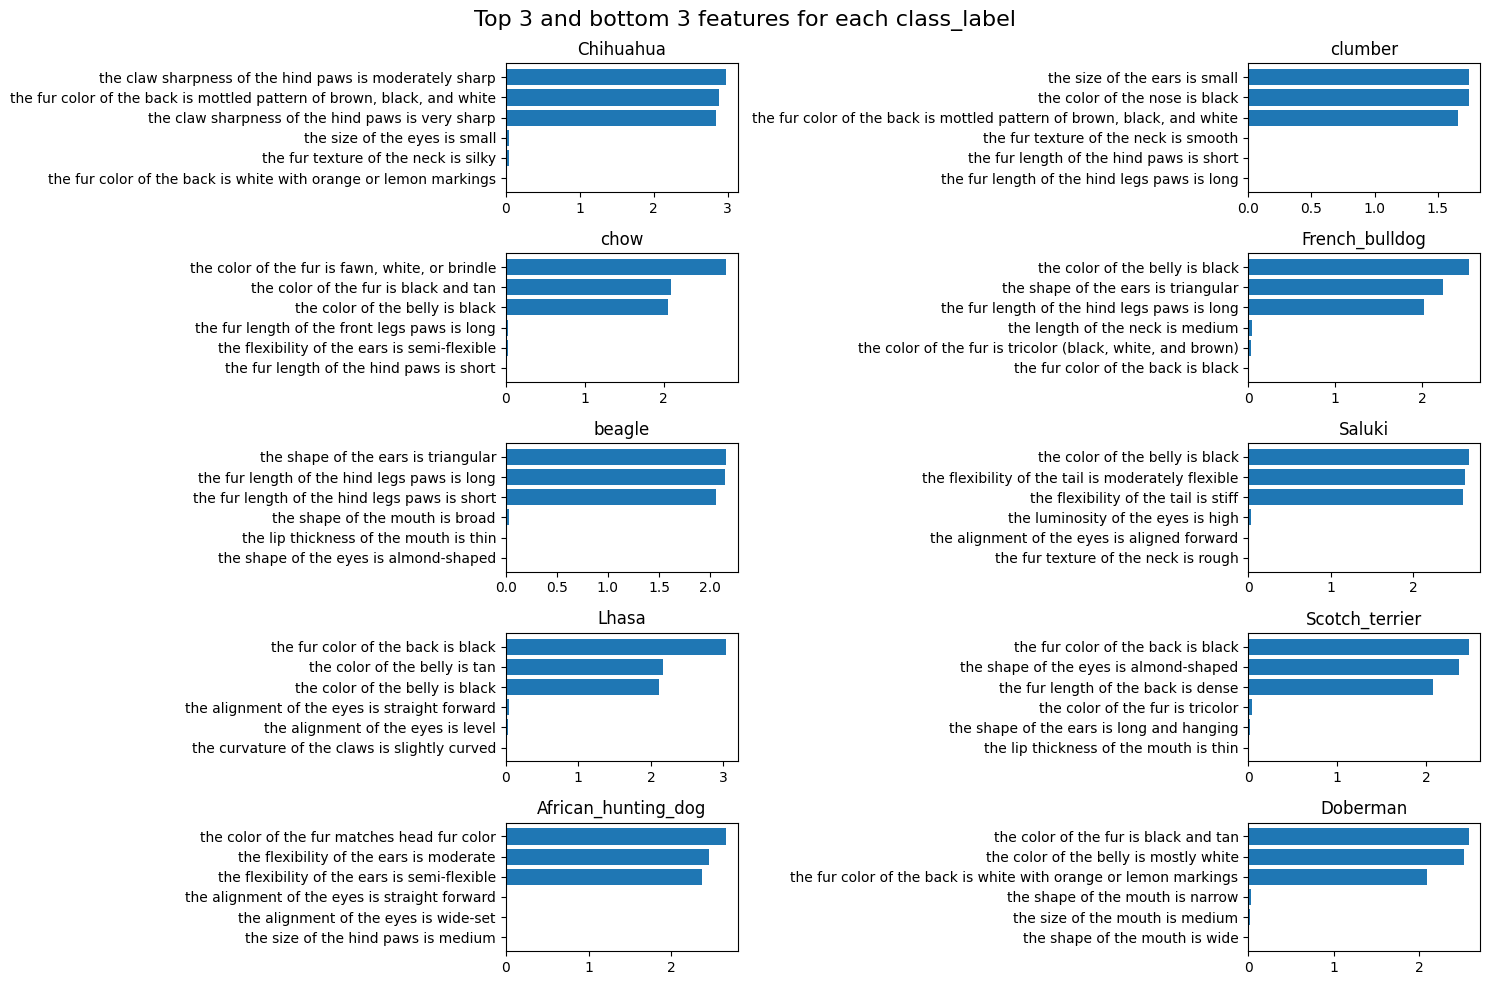

In [179]:
n_classes = len(feature_importances.columns)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axes_flat = axes.flatten()

for i, class_label in enumerate(feature_importances.columns):
    top_features = feature_importances[class_label].nlargest(3)
    bottom_features = feature_importances[class_label].nsmallest(3)

    combined_features = pd.concat([top_features, bottom_features])
    combined_features = combined_features.reindex(combined_features.abs().sort_values(ascending=True).index)

    ax = axes_flat[i]
    ax.barh(combined_features.index, combined_features)
    ax.set_title(f"{class_label}")
    ax.axvline(x=0, color='grey', linewidth=0.5)  # Line at zero for reference

fig.suptitle('Top 3 and bottom 3 features for each class_label', fontsize=16)
plt.tight_layout()
plt.show()

## Focus on confusing class_labels

In [185]:
class_label1 = 'Chihuahua'
class_label2 = 'beagle'

top_features_class_label1 = feature_importances[class_label1].nlargest(20).index
top_features_class_label2 = feature_importances[class_label2].nlargest(20).index
common_features = top_features_class_label1.intersection(top_features_class_label2)
common_feature_values = feature_importances.loc[common_features, [class_label1, class_label2]]
common_feature_values

Chihuahua    beagle
the claw sharpness of the hind paws is moderate...   2.984386  1.505223
the claw sharpness of the hind paws is very sharp    2.848511  1.751622
the fur length of the hind paws is dense             2.564957  1.671415
the claw sharpness of the hind legs paws is mod...   2.163042  1.935510
the fur length of the hind paws is short             2.052233  1.558943
the color of the belly is mostly white               1.925936  1.468726
the claw sharpness of the hind_legs paws is mod...   1.742660  1.837048
the fur length of the hind legs paws is long         1.348459  2.145686
the size of the front paws is small                  1.326206  1.444011
the fur length of the hind legs paws is short        1.307899  2.061689

## Specific image prediction

In [74]:
def image_prediction_output(image_name, image_dir, label_dir, annotation_dir, text_embeddings, model):
    
    image_path = os.path.join(image_dir, label_dir, image_name+'.jpg')
    annotation_path = os.path.join(annotation_dir, label_dir, image_name)
    
    bounding_boxes = parse_annotation(annotation_path)
    image = Image.open(image_path)
    cropped_image = image.crop(bounding_boxes[0])

    image_text_similarities = get_image_cosine_similarities(image_name=image_name,
                                                            image_dir=image_dir,
                                                            label_dir=label_dir,
                                                            annotation_dir=annotation_dir,
                                                            text_embeddings=text_embeddings)
    
    df_pred = pd.DataFrame.from_dict(image_text_similarities, orient='index').T
    df_pred = df_pred[X_test.columns]
    
    print(f"\nthe true class_label is : {label_dir.split('-')[1]}")
    print(f"the predicted class_label is : {model.predict(df_pred)[0]}")
    
    probas = list(model.predict_proba(df_pred)[0])
    class_labels = list(model.classes_)
    prediction_probas = dict(zip(class_labels, probas))
    sorted_prediction_probas = dict(sorted(prediction_probas.items(), key=lambda item: item[1], reverse=False))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) #gridspec_kw={'width_ratios': [1.5, 1]}
                                   
    ax1.imshow(cropped_image)
    ax1.axis('off')
    
    ax2.barh(sorted_prediction_probas.keys(), sorted_prediction_probas.values(), color='skyblue')
    ax2.set_title('Model output probabilities for each class_label')


the true class_label is : clumber
the predicted class_label is : Saluki


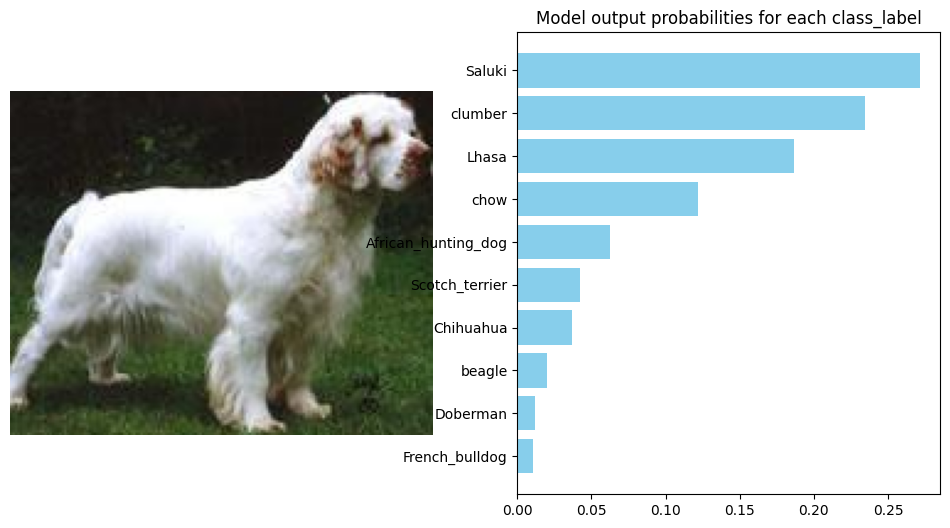

In [75]:
image_dir='../stanford-dogs/images/Images'
annotation_dir = '../stanford-dogs/annotations/Annotation'
label_dir = 'n02101556-clumber'
image_name = 'n02101556_7295'


image_prediction_output(image_name, image_dir, label_dir, annotation_dir, visual_clues_embeddings, model)

# Compare with CNN model

In [188]:
# Define paths
base_dir = "../stanford-dogs"
images_dir = os.path.join(base_dir, "images", "Images")
annotations_dir = os.path.join(base_dir, "annotations", "Annotation")

# Prepare the dataset by parsing annotations and cropping images
def parse_annotations():
    data = []
    for breed_folder in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, breed_folder)
        image_path = os.path.join(images_dir, breed_folder)

        if not os.path.isdir(annotation_path):
            continue

        for annotation_file in os.listdir(annotation_path):
            annotation_file_path = os.path.join(annotation_path, annotation_file)
            image_file = f"{annotation_file}.jpg"
            image_file_path = os.path.join(image_path, image_file)

            if not os.path.exists(image_file_path):
                continue

            # Parse XML to get bounding box
            tree = ET.parse(annotation_file_path)
            root = tree.getroot()
            bndbox = root.find(".//bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Save record
            label = breed_folder
            data.append({
                "image_path": image_file_path,
                "bbox": (xmin, ymin, xmax, ymax),
                "label": label
            })
    return data

# Custom dataset class to handle cropping and transforms
class StanfordDogsDataset(Dataset):
    def __init__(self, data, transform=None, label_map=None):
        self.data = data
        self.transform = transform
        self.label_map = label_map or {label: idx for idx, label in enumerate(sorted({d['label'] for d in data}))}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data[idx]
        image = Image.open(record["image_path"]).convert("RGB")
        xmin, ymin, xmax, ymax = record["bbox"]
        image = image.crop((xmin, ymin, xmax, ymax))  # Crop the image
        label = self.label_map[record["label"]]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Parse dataset
data = parse_annotations()

# Create train/test split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=[d["label"] for d in data])

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize datasets and dataloaders
label_map = {label: idx for idx, label in enumerate(sorted({d['label'] for d in data}))}
train_dataset = StanfordDogsDataset(train_data, transform=transform, label_map=label_map)
test_dataset = StanfordDogsDataset(test_data, transform=transform, label_map=label_map)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [189]:
label_map

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [ ]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Reduce filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Smaller fully connected layer
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Epoch 1/5, Loss: 4.4189, Accuracy: 3.60%
Epoch 2/5, Loss: 3.9144, Accuracy: 9.69%
Epoch 3/5, Loss: 3.3292, Accuracy: 19.44%


In [ ]:
# comparer les accuracies
# comparer les matrices de confusion

In [195]:
100 * correct / total

10.276967930029155

In [196]:
epoch

4

In [53]:
import shap

In [54]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

/opt/conda/envs/libsearch/lib/python3.10/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [72]:
np.array(X_test.loc[522,:]).reshape(1, -1)

array([[0.17201468348503113, 0.2620242238044739, 0.12836572527885437,
        0.14925040304660797, 0.178737610578537, 0.2039785385131836,
        0.15250781178474426, 0.13231103122234344, 0.2568787932395935,
        0.19623415172100067, 0.19575859606266022, 0.17254357039928436,
        0.20957663655281067, 0.15956981480121613, 0.20182017982006073,
        0.23057007789611816, 0.18970254063606262, 0.15936774015426636,
        0.1591978371143341, 0.20129279792308807, 0.1724867969751358,
        0.15209615230560303, 0.1704104095697403, 0.2384907752275467,
        0.21884307265281677, 0.17010921239852905, 0.21173858642578125,
        0.21737290918827057, 0.19698132574558258, 0.17530293762683868,
        0.1161317229270935, 0.16263508796691895, 0.15745052695274353,
        0.14748142659664154, 0.21274802088737488, 0.12959101796150208,
        0.20511147379875183, 0.19794626533985138, 0.16222171485424042,
        0.14802880585193634, 0.2112034559249878, 0.15738704800605774,
        0.1529981

In [86]:
# Select a single prediction (e.g., the first instance in the test set)
single_instance = np.array(X_test.loc[522,:]).reshape(1, -1)

# Calculate SHAP values
shap_values = explainer.shap_values(single_instance)
shap_values = np.array(shap_values)

In [88]:
shap_values

array([[[0.0037559868978051603, -0.0011425275392407815,
         0.007172276829085328, ..., 0.014210862600999108,
         -0.014169852894728507, 0.004729725814992302],
        [0.009253950892238355, 0.022259421910692835,
         -0.006628032547631083, ..., 0.041090012053863145,
         -0.06315386292528415, -0.011142774562321996],
        [-0.06890277824100498, -0.02334767539655828,
         -0.039833442519770015, ..., 0.0018221691439576065,
         -0.045028726778229305, 0.011710953239428102],
        ...,
        [-0.013977978649755321, 0.005310477401679877,
         0.019042243698407322, ..., 0.016158345202350568,
         -0.014633289751374415, -0.003480676580521097],
        [-0.009832823058921589, 0.005488516677768631,
         -0.006739492867076035, ..., 0.008008162669137623,
         0.0014508877130412217, -0.007871359969005913],
        [-0.009490216890347522, -0.002758398872063294,
         0.0017504890787718927, ..., -0.0080002959040555,
         -0.01373590039034573, -0

In [90]:
# Get feature names (or provide your own feature names)
feature_names = list(X_train.columns)

# Combine feature names and SHAP values into a DataFrame
shap_df = pd.DataFrame({
    "feature": feature_names,
    "shap_value": shap_values,
    "feature_value": single_instance.flatten()
})

# Sort by absolute SHAP value to get the top features
shap_df["abs_shap_value"] = shap_df["shap_value"].abs()
shap_df = shap_df.sort_values(by="abs_shap_value", ascending=False)

# Select the top N features
top_n = 3  # Adjust this to show more or fewer top features
top_features = shap_df.head(top_n)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["shap_value"], color="skyblue")
plt.xlabel("SHAP value (impact on model output)")
plt.title(f"Top {top_n} features for prediction (class {predicted_class})")
plt.gca().invert_yaxis()
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

In [84]:
# Select the predicted class
predicted_class = model.predict(single_instance)[0]

# Display SHAP values for the predicted class
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], single_instance, feature_names=list(X_train.columns))

/opt/conda/envs/libsearch/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


IndexError: index 1 is out of bounds for axis 0 with size 1

## test cells

In [18]:
image_dir = '../stanford-dogs/images/Images'
annotation_dir = '../stanford-dogs/annotations/Annotation'

label_dir = 'n02097298-Scotch_terrier'

image_name = 'n02097298_11346.jpg'
annotation_name = 'n02097298_11346'

image_path = os.path.join(image_dir, label_dir, image_name)
annotation_path = os.path.join(annotation_dir, label_dir, annotation_name)

In [19]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    bboxes = []
    
    # Extract bounding box coordinates
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((xmin, ymin, xmax, ymax))
    
    return bboxes

# Get bounding boxes for the chosen annotation
bounding_boxes = parse_annotation(annotation_path)

In [20]:
bounding_boxes

[(1, 67, 252, 311)]

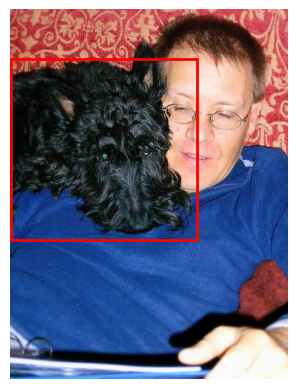

In [21]:
# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

# Plot bounding boxes on the image
for (xmin, ymin, xmax, ymax) in bounding_boxes:
    # Draw a rectangle around the annotated object
    plt.gca().add_patch(
        plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2)
    )

plt.show()

In [51]:
bounding_boxes

[(1, 67, 252, 311)]

(-0.5, 250.5, 243.5, -0.5)

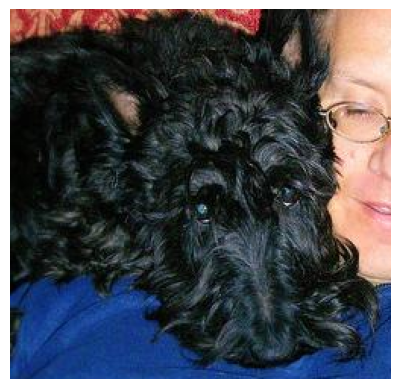

In [52]:
cropped_image = image.crop(bounding_boxes[0])
plt.imshow(cropped_image)
plt.axis('off')

In [44]:
clip_embd = OpenCLIPEmbeddings(model_name="ViT-B-32", checkpoint="laion2b_s34b_b79k")

In [50]:
import open_clip
import torch

# Load OpenCLIP model and preprocessing function
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [57]:
cropped_image = image.crop(bounding_boxes[0])

inputs = preprocess(cropped_image).unsqueeze(0)

with torch.no_grad():
    img_embedding = model.encode_image(inputs)

In [58]:
img_embedding

tensor([[ 1.0978e-01,  4.2748e-01,  2.5231e-01, -1.1178e-01, -5.6878e-02,
          7.1148e-02,  4.3656e-01, -6.7652e-02,  2.3147e-01,  4.2374e-01,
          1.5545e-01,  2.0119e-01, -2.1384e-01, -9.1399e-01,  6.8477e-01,
          3.3699e-01, -6.1499e-01,  2.0084e-02, -1.2033e-01,  3.9113e-01,
         -2.6651e-01,  6.5477e-01, -3.0600e-01,  4.5119e-01, -4.1928e-01,
         -2.1610e-01,  4.1662e-01,  1.8855e-01, -8.8057e-01,  1.3654e-01,
         -5.4120e-01,  3.0995e-01, -2.1130e-01,  2.8382e-01,  3.5053e-01,
          7.1175e-01, -1.9462e-01,  7.7290e-01, -3.9429e-01, -5.6612e-03,
          3.2419e-02,  6.0560e-02, -1.7788e-01, -3.8617e-01,  1.2897e-01,
         -4.0782e-01, -8.3052e-02, -8.9206e-02, -6.4987e-02,  3.0590e-01,
          7.1021e-02,  2.1497e-02, -3.1428e-01, -1.7500e-02,  5.6394e-01,
         -3.2848e-01, -2.6857e-01,  2.8357e-01, -1.9766e-01,  4.2666e-01,
          1.1222e+00,  1.4607e-01,  1.1525e-01,  3.5897e-01,  5.4682e-01,
          8.8683e-03,  2.2857e-01, -7.

In [55]:
def get_text_embeddings(texts):
    text_embeddings = []
    
    for text in texts:
        # Tokenize and embed text
        tokens = open_clip.tokenize([text])  # Tokenize text for CLIP
        with torch.no_grad():
            text_embedding = model.encode_text(tokens)
        
        # Store embedding
        text_embeddings.append(text_embedding)
    
    return text_embeddings

In [59]:
txt_embeddings = get_text_embeddings(visual_clues_list)

In [61]:
txt_embeddings[1]

tensor([[ 3.0078e-01, -7.2302e-02, -2.0730e-01, -4.6254e-01,  2.0678e-01,
         -1.9351e-01,  2.7950e-01, -1.2383e-01, -1.4327e-01, -1.6860e-02,
          9.8521e-02,  2.1734e-01, -6.2688e-01, -1.2490e-01,  3.1225e-01,
         -3.1796e-02, -1.7145e+00,  8.4966e-02, -4.1858e-01,  4.2619e-02,
         -7.5939e-02, -7.6013e-02,  5.6274e-02,  2.2857e-01,  2.8425e-01,
          4.4230e-01,  4.2274e-02,  4.9141e-01,  9.6278e-03, -7.9250e-02,
          3.2946e-01,  6.3199e-01,  7.2959e-02, -1.4670e-01, -2.2924e-01,
          3.9225e-01,  1.3663e-01,  2.3485e-01, -2.0329e-01, -2.2691e-01,
          5.2997e-02, -3.3930e-01,  6.5291e-02,  4.1671e-01,  7.7847e-02,
         -1.6343e-01,  2.6157e-02, -5.5898e-01,  1.5324e-01, -2.2550e-02,
         -1.2722e-01, -1.2482e-01,  4.7043e-01, -2.8591e-02,  3.3790e-01,
          1.1889e-01, -5.9922e-02, -5.2373e-01, -5.8457e-02,  1.6515e-01,
          4.2888e-02,  7.1136e-02, -2.5411e-01, -1.5773e-01, -1.4113e-01,
          2.1096e-01, -1.1743e-01, -1.

In [64]:
import torch.nn.functional as F

def calculate_cosine_similarities(image_embedding, text_embeddings):
    cosine_similarities = []
    for text_emb in text_embeddings:
        similarity = F.cosine_similarity(image_embedding, text_emb, dim=-1)
        #similarity = np.matmul(text_emb, image_embedding.T)
        cosine_similarities.append(similarity.item())  # Convert to Python float
    return cosine_similarities

In [65]:
similarities = calculate_cosine_similarities(img_embedding, txt_embeddings)

In [66]:
similarities

[0.2097967118024826,
 0.20071645081043243,
 0.14595764875411987,
 0.17503738403320312,
 0.17961183190345764,
 0.23302070796489716,
 0.1754952371120453,
 0.19189834594726562,
 0.2291642427444458,
 0.2210899144411087,
 0.224979430437088,
 0.18952831625938416,
 0.24144326150417328,
 0.16893935203552246,
 0.15544910728931427,
 0.1913594901561737,
 0.18278725445270538,
 0.16279840469360352,
 0.23372671008110046,
 0.21358966827392578,
 0.1726621389389038,
 0.22160682082176208,
 0.17171822488307953,
 0.19939137995243073,
 0.22556371986865997,
 0.17396031320095062,
 0.18586014211177826,
 0.24070128798484802,
 0.20189817249774933,
 0.2037828415632248,
 0.2182026207447052,
 0.23372671008110046,
 0.21358966827392578,
 0.1726621389389038,
 0.22160682082176208,
 0.237547367811203,
 0.2309200018644333,
 0.2317340224981308,
 0.237547367811203,
 0.2309200018644333,
 0.2317340224981308,
 0.17293602228164673,
 0.20307381451129913,
 0.1600867360830307,
 0.22530117630958557,
 0.15535426139831543,
 0.15178

In [69]:
np.mean(similarities)

0.2003291385869185

In [86]:
visual_clues_lists = {
    'bulldog' : visual_clues_list_bulldog,
    'scotch_terrier': visual_clues_list_scotch_terrier
}

In [88]:
len(visual_clues_lists['bulldog'])

65

In [89]:
len(visual_clues_lists['scotch_terrier'])

40

In [ ]:
visual_clues_class_domain_dict

In [ ]:
visual_clues_class_domain_dict_embedding = {}
for class_label, visual_clue_list in visual_clues_class_domain_dict.items():
    visual_clues_class_domain_dict_embedding[

In [95]:
visual_clues_class_domain_dict_embedding = {class_label:get_text_embeddings(visual_clue_list) for class_label, visual_clue_list in visual_clues_class_domain_dict.items()}

In [96]:
visual_clues_class_domain_dict_embedding

{'bulldog': [tensor([[ 4.0503e-02,  8.8710e-02, -5.6134e-02, -5.4037e-01, -1.1503e-01,
           -1.1515e-01,  1.2256e-01, -1.6536e-01,  1.9727e-02, -2.0380e-03,
           -5.0365e-02,  1.4682e-01, -1.5893e-01,  1.4998e-02,  6.2514e-01,
            7.5711e-02, -1.4550e+00,  9.1009e-02, -1.3593e-01, -6.1723e-01,
            3.7732e-02, -1.2777e-02,  2.5865e-01,  2.2551e-01,  4.6683e-03,
           -5.0191e-02,  2.5049e-01,  3.9947e-01,  1.1210e-01, -1.0544e-02,
            1.7898e-01,  1.6855e-01,  4.2010e-03, -1.8458e-01, -3.2549e-01,
            5.2155e-01, -3.2852e-03,  5.9891e-01,  1.3991e-01, -1.4987e-01,
           -3.1915e-01, -2.4995e-01,  1.6806e-01,  1.2721e-01, -5.4326e-01,
            6.4199e-01, -4.0928e-03, -2.6228e-01,  3.2317e-01, -1.1174e-01,
            2.4961e-02,  1.8156e-01,  3.4163e-01,  2.8929e-03,  2.8466e-02,
           -1.7364e-02,  1.9854e-01, -5.2485e-01, -3.2026e-01,  2.5132e-01,
            4.7610e-01, -3.4430e-01, -3.2705e-01,  6.2203e-02, -3.7703e-01,
 

In [98]:
image_similarities = {class_label: calculate_cosine_similarities(img_embedding, visual_clues_class_label_list_embedding) for class_label, visual_clues_class_label_list_embedding in visual_clues_class_domain_dict_embedding.items()}

In [101]:
np.mean(image_similarities['bulldog'])

0.19817503209297474

In [102]:
np.mean(image_similarities['scotch_terrier'])

0.20592129597297082

In [103]:
image_similarities

{'bulldog': [0.2097967118024826,
  0.21170733869075775,
  0.16369585692882538,
  0.17503738403320312,
  0.18481074273586273,
  0.23906439542770386,
  0.2172347903251648,
  0.19189834594726562,
  0.22855360805988312,
  0.23776203393936157,
  0.22419214248657227,
  0.17422975599765778,
  0.24144326150417328,
  0.16893935203552246,
  0.2065829187631607,
  0.15544910728931427,
  0.1913594901561737,
  0.18278725445270538,
  0.17558324337005615,
  0.19630955159664154,
  0.17408624291419983,
  0.18015563488006592,
  0.21358966827392578,
  0.22160682082176208,
  0.21318118274211884,
  0.17171822488307953,
  0.19939137995243073,
  0.22556371986865997,
  0.17456293106079102,
  0.16057157516479492,
  0.17396031320095062,
  0.2250400185585022,
  0.16020621359348297,
  0.1371462643146515,
  0.18310950696468353,
  0.20501816272735596,
  0.21085213124752045,
  0.20275728404521942,
  0.18752124905586243,
  0.1560678780078888,
  0.17408624291419983,
  0.18015563488006592,
  0.21358966827392578,
  0.221

In [104]:
result = [1 if a > b else 0 for a, b in zip(image_similarities['scotch_terrier'], image_similarities['bulldog'])]

In [107]:
sum(result) / len(image_similarities['scotch_terrier'])

0.3076923076923077